# Part 2 - Response to lingual features

In [2]:
import itertools
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
from julia_linear_mm import Bernoulli, Normal, run_linear_mm
from plotly.subplots import make_subplots
from constants import (
    colors,
    outcome_name_mapping,
)
from process_IA_rep_for_reread_analysis import (
    process_df_for_reread_analysis,
    upload,
)
from response_to_ling import config
from tqdm import tqdm

warnings.filterwarnings("ignore")
import plotly.graph_objects as go


In [3]:
data = pd.read_csv(
    "/data/home/shared/onestop/processed/ia_data_enriched_360_18042024.csv",
    engine="pyarrow",
)
# remove all columns with _Surprisal in them except for gpt2_Surprisal and prev_gpt2_Surprisal
cols_to_keep = ["gpt2_Surprisal", "prev_gpt2_Surprisal"]
cols_to_drop = [
    col for col in data.columns if "_Surprisal" in col and col not in cols_to_keep
]
data = data.drop(columns=cols_to_drop)

et_data_enriched = process_df_for_reread_analysis(data=data)

et_data_enriched = et_data_enriched.query("IA_DWELL_TIME < 10000")

et_data_enriched["IA_ZERO_TF"] = et_data_enriched["IA_DWELL_TIME"] == 0

Exclude IAs
Adding paragraph_length column...
Splitting unique_paragraph_id to original columns
Adding add_first_read_out_of_2_column indicator column...
Adding experiment_IA_numbering indicator column...
Adding paragraph_numbering column...
Adding article_ind_diff_from_first_reading column for articles 11 and 12...
article_ind
paragraph_numbering
experiment_IA_numbering
reread
Adding variables indicating rereading trials with the          same / different critical span as in the first reading


In [4]:
all_outcomes = [
    "IA_FIRST_FIXATION_DURATION",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_FIRST_PASS_GAZE_DURATION",
    "IA_RUN_COUNT",
    "IA_ZERO_TF",
    "IA_REGRESSION_OUT_FULL_COUNT",
]

In [5]:
explanatory_var_class_names = {
    "reread": {
        0: "First reading",
        1: "Repeated Reading",
        "0": "First Reading",
        "1": "Repeated Reading",
    },
    "has_preview_reread": {
        "Gathering_1": "Gathering, RR",
        "Gathering_0": "Gathering, Not RR",
        "Hunting_1": "Hunting, RR",
        "Hunting_0": "Hunting, Not RR",
    },
    "has_preview": {
        "Hunting": "Hunting",
        "Gathering": "Gathering",
    },
}

explanatory_var_names = {
    "has_preview": "Condition",
    "relative_to_aspan": "Relative to Critical Span",
    "article_ind_of_first_reading": "Article Index of the First Reading",
    "first_second_reading_types": "First (<10, 10) and Second (11, 12) Readings",
    "article_ind_group_of_first_reading": "Article Index of the First Reading",
    "reread": "Reread",
    "has_preview_reread": "Condition and Reread",
}

## Reread, has_preview 

In [6]:



# # init wandb
# import wandb
# wandb.login()

z_score_w_r_t_explanatory = False

evs = ["reread", "has_preview"]
# ev_list = ["article_ind_of_first_reading"]

In [7]:
def plot_response_hp_rr(res):
    fig = sp.make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["Surprisal", "Frequency", "Length"],
        vertical_spacing=0.1,
    )

    reread_vars = [0, 1]
    fsrt_colors = colors[0:3]

    for i, ling_feature in enumerate(
        ["gpt2_Surprisal", "Wordfreq_Frequency", "Length"]
    ):
        # add a secondary x axis for the first_second_reading_types

        for j, rr_val in enumerate(reread_vars):
            hp_res = res.loc[lambda x: x["reread"] == rr_val]
            fig.add_trace(
                go.Bar(
                    x=hp_res.loc[lambda x: x["Name"] == ling_feature]["has_preview"],
                    y=hp_res.loc[lambda x: x["Name"] == ling_feature]["Coef."],
                    error_y=dict(
                        type="data",
                        array=hp_res.loc[lambda x: x["Name"] == ling_feature][
                            "Std. Error"
                        ]
                        * 2,
                    ),
                    name="First Reading" if j == 0 else "Repeated Reading",
                    marker=dict(color=fsrt_colors[j]),
                    showlegend=True if i == 0 else False,
                ),
                row=1,
                col=i + 1,
            )
        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            yaxis=dict(gridcolor="LightGray"),
        )

        fig.update_yaxes(
            title_text="Coefficient" if i == 0 else "",
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=1,
            col=i + 1,
        )

    fig.update_layout(
        height=350,
        width=1000,
    )

    # increse all font by 10
    fig.update_layout(font=dict(size=25))
    fig.update_annotations(font_size=25)

    for i in range(3):
        # turn the grid background to white
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"
    # remove all margins
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0))
    # move the legend to the bottom
    fig = fig.update_layout(
        legend=dict(
            yanchor="bottom",
            y=-0.35,
            xanchor="center",
            x=0.5,
            font=dict(size=25),
            orientation="h",
        )
    )
    fig.show(renderer="png")
    return fig


def upload_response_hp_rr_graph(fig, mode, outcome):
    if mode == "standard":
        upload(
            fig,
            "CogSci 2024 - Rereading",
            f"{'main_figures' if outcome == 'IA_DWELL_TIME' else 'sm_figures'}/{outcome + '_' if outcome != 'IA_DWELL_TIME' else ''}response_to_ling_reread_has_preview_raw_RT.pdf",
        )
    elif mode == "z_has_preview":
        upload(
            fig,
            "CogSci 2024 - Rereading",
            f"{'sm_figures'}/{outcome + '_' if outcome != 'IA_DWELL_TIME' else ''}response_to_ling_reread_has_preview_Z_RT_wrt_has_preview.pdf",
        )
    elif mode == "z_reread":
        upload(
            fig,
            "CogSci 2024 - Rereading",
            f"{'sm_figures'}/{outcome + '_' if outcome != 'IA_DWELL_TIME' else ''}response_to_ling_reread_has_preview_Z_RT_wrt_reread.pdf",
        )
    elif mode == "z_combination":
        upload(
            fig,
            "CogSci 2024 - Rereading",
            f"{'sm_figures'}/{outcome + '_' if outcome != 'IA_DWELL_TIME' else ''}response_to_ling_reread_has_preview_Z_RT_wrt_combination.pdf",
        )
    elif mode == "posi":
        upload(
            fig,
            "CogSci 2024 - Rereading",
            f"{'sm_figures'}/{outcome + '_' if outcome != 'IA_DWELL_TIME' else ''}response_to_ling_reread_has_preview_Z_RT_wrt_posi.pdf",
        )

standard IA_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -5140203.5170 10280407.0340 10280465.0340 10280465.0363 10280799.7102

Variance components:
                          Column         Variance   Std.Dev.   Corr.
unique_paragraph_id (Intercept)           476.56177  21.83029
                    Wordfreq_Frequency     12.82820   3.58165 +0.11
                    gpt2_Surprisal         16.75559   4.09336 +0.22 -0.28
                    Length                 39.44452   6.28049 +0.48 -0.60 +0.19
subject_id          (Intercept)          4775.59919  69.10571
                    Wordfreq_Frequency 

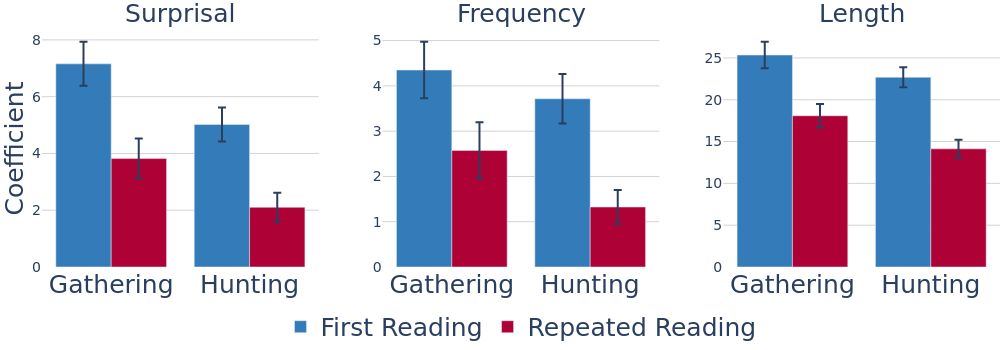

standard IA_FIRST_FIXATION_DURATION
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_FIRST_FIXATION_DURATION ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -4620145.4511  9240290.9023  9240348.9023  9240348.9046  9240683.5785

Variance components:
                          Column         Variance   Std.Dev.   Corr.
unique_paragraph_id (Intercept)            37.04121   6.08615
                    Wordfreq_Frequency      1.65090   1.28487 +0.23
                    gpt2_Surprisal          1.22825   1.10827 -0.02 -0.40
                    Length                  2.78460   1.66871 -0.33 -0.65 +0.16
subject_id          (Intercept)           876.03499  29.59789
             

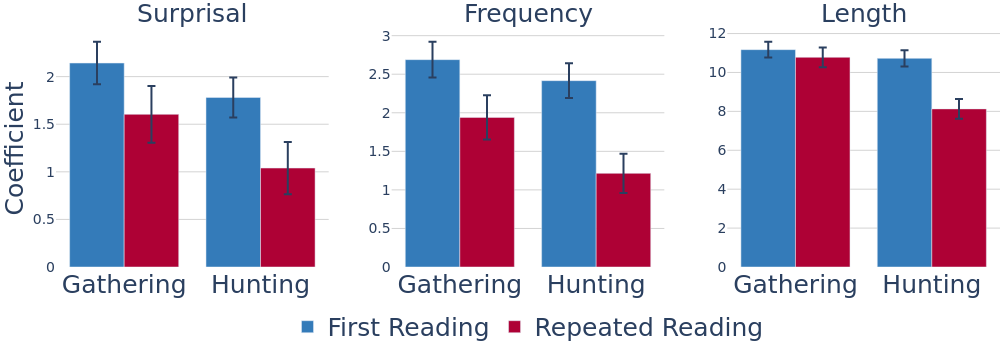

standard IA_FIRST_RUN_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_FIRST_RUN_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -4732398.6432  9464797.2865  9464855.2865  9464855.2888  9465189.9627

Variance components:
                          Column         Variance   Std.Dev.   Corr.
unique_paragraph_id (Intercept)            52.03459   7.21350
                    Wordfreq_Frequency      3.28442   1.81230 +0.26
                    gpt2_Surprisal          2.95339   1.71854 +0.05 -0.30
                    Length                  4.72110   2.17281 -0.09 -0.61 +0.11
subject_id          (Intercept)          1344.11689  36.66220
                   

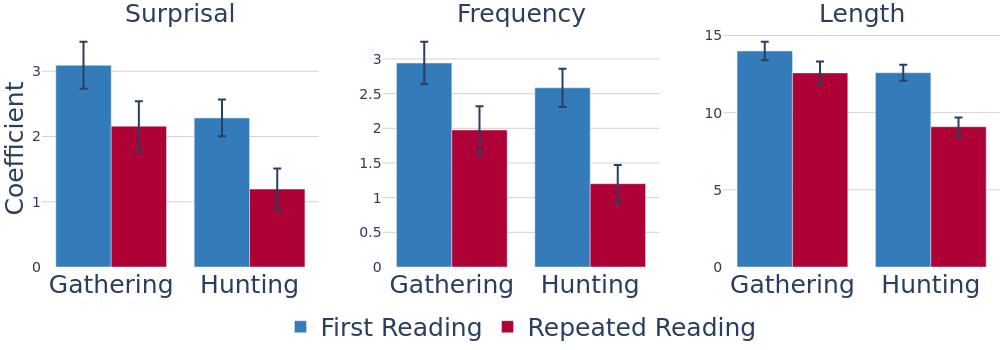

z_combination IA_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -971359.6008 1942719.2015 1942777.2015 1942777.2038 1943111.8778

Variance components:
                          Column        Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)         0.0081540 0.0902994
                    Wordfreq_Frequency  0.0002193 0.0148074 +0.11
                    gpt2_Surprisal      0.0002865 0.0169267 +0.22 -0.28
                    Length              0.0006743 0.0259667 +0.48 -0.60 +0.19
subject_id          (Intercept)         0.0818066 0.2860186
                    Wordfreq_Frequency  0.0001451 0.0120

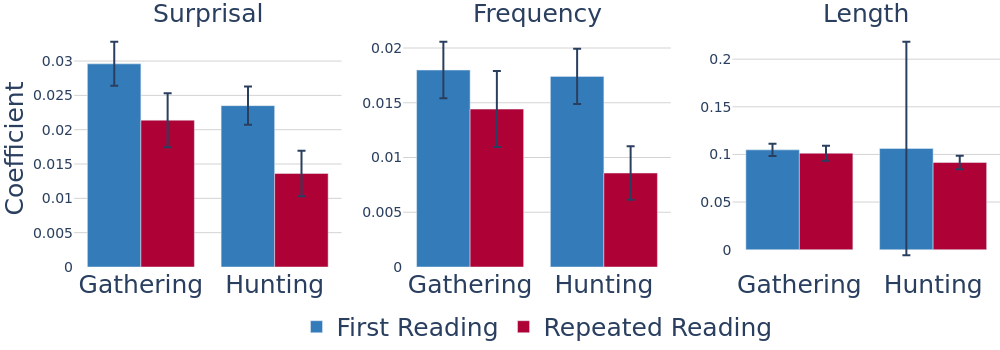

z_combination IA_FIRST_FIXATION_DURATION
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_FIRST_FIXATION_DURATION ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -1004856.5448  2009713.0897  2009771.0897  2009771.0920  2010105.7659

Variance components:
                          Column        Variance   Std.Dev.    Corr.
unique_paragraph_id (Intercept)         0.00272265 0.05217899
                    Wordfreq_Frequency  0.00012134 0.01101564 +0.23
                    gpt2_Surprisal      0.00009021 0.00949779 -0.02 -0.41
                    Length              0.00020473 0.01430836 -0.33 -0.65 +0.16
subject_id          (Intercept)         0.06418761 0.25335274
        

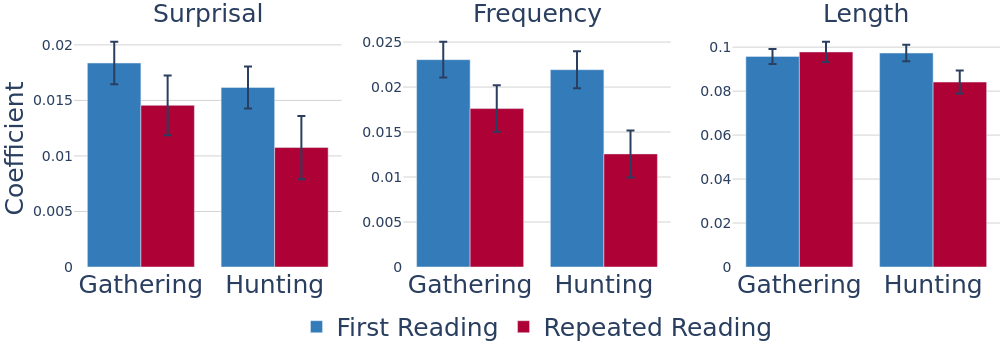

z_combination IA_FIRST_RUN_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_FIRST_RUN_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -990963.7078 1981927.4155 1981985.4155 1981985.4178 1982320.0918

Variance components:
                          Column        Variance   Std.Dev.    Corr.
unique_paragraph_id (Intercept)         0.00274129 0.05235734
                    Wordfreq_Frequency  0.00017319 0.01316003 +0.26
                    gpt2_Surprisal      0.00015572 0.01247881 +0.05 -0.30
                    Length              0.00024906 0.01578161 -0.09 -0.61 +0.11
subject_id          (Intercept)         0.07085242 0.26618118
                    Word

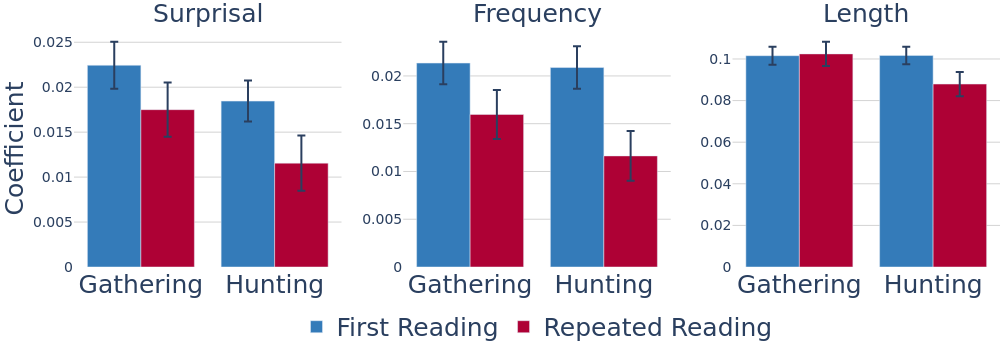

In [13]:
for mode in ["standard", "z_combination"]:
    for outcome in [
        "IA_DWELL_TIME",
        "IA_FIRST_FIXATION_DURATION",
        "IA_FIRST_RUN_DWELL_TIME",
    ]:
        print("================================================")
        print(mode, outcome)
        print("================================================")
        # outcome = 'IA_FIRST_RUN_DWELL_TIME'

        df_query = f"{outcome} >= 0" if mode != "posi" else f"{outcome} > 0"
        if df_query != "":
            df = et_data_enriched.query(df_query).copy()
            # df['IA_DWELL_TIME'] = np.log(df["IA_DWELL_TIME"])
        else:
            df = et_data_enriched.copy()

        # centralize the covariates
        df["Wordfreq_Frequency"] = (
            df["Wordfreq_Frequency"] - df["Wordfreq_Frequency"].mean()
        )
        df["gpt2_Surprisal"] = df["gpt2_Surprisal"] - df["gpt2_Surprisal"].mean()
        df["Length"] = df["Length"] - df["Length"].mean()
        df["prev_Wordfreq_Frequency"] = (
            df["prev_Wordfreq_Frequency"] - df["Wordfreq_Frequency"].mean()
        )
        df["prev_gpt2_Surprisal"] = (
            df["prev_gpt2_Surprisal"] - df["gpt2_Surprisal"].mean()
        )
        df["prev_Length"] = df["prev_Length"] - df["Length"].mean()

        # take df, and normalize the ourcome variable seperately for Hunting and Gathering

        if mode == "z_has_preview":
            df[outcome] = df.groupby("has_preview")[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )

        if mode == "z_reread":
            df[outcome] = df.groupby("reread")[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )

        if mode == "z_combination":
            result = df.groupby(["has_preview", "reread"])[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )
            df[outcome] = result.reset_index(level=0, drop=True).reset_index(
                level=0, drop=True
            )

        cfg = config()
        cfg.outcome_variable = outcome

        cfg.z_score_w_r_t_explanatory = z_score_w_r_t_explanatory
        z_score_text = "" if not cfg.z_score_w_r_t_explanatory else " (z-scored)"
        ling_featurse_formula = f"""
        {cfg.outcome_variable} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
            (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
            (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
        """
        cfg.model_formula = ling_featurse_formula

        cfg.explanatory_variable = evs

        if isinstance(evs, list) and len(evs) > 1:
            cfg.explanatory_variable = "_".join(evs)
            df[cfg.explanatory_variable] = df[evs].apply(
                lambda x: "_".join([str(i) for i in x]), axis=1
            )

        res = (
            df.groupby(cfg.explanatory_variable)
            .apply(
                lambda x: run_linear_mm(
                    x,
                    cfg.outcome_variable,
                    cfg.re_columns,
                    ling_featurse_formula,
                    model_res_var_name="j_model_mm",
                    link_dist=Normal()
                    if cfg.outcome_variable != "IA_SKIP"
                    else Bernoulli(),
                    z_outcome=z_score_w_r_t_explanatory,
                    centralize_covariates=False,
                )[0]
            )
            .reset_index()
            .drop(columns=["level_1"])
        )

        if len(evs) > 1:
            # seperate the explanatory variable into its components in res
            res[cfg.explanatory_variable] = res[cfg.explanatory_variable].apply(
                lambda x: x.split("_")
            )
            for i in range(len(evs)):
                res[evs[i]] = res[cfg.explanatory_variable].apply(lambda x: x[i])
            res = res.drop(columns=[cfg.explanatory_variable]) # type: ignore
            # turn the numeric evs back to numeric if it's possible (is_numeric)
            for ev in evs:
                res[ev] = pd.to_numeric(res[ev], errors="ignore") # type: ignore

        # remove from res the interaction term
        res = res.query("Name != 'Wordfreq_Frequency & Length'")

        fig = plot_response_hp_rr(res)
        upload_response_hp_rr_graph(fig=fig, mode=mode, outcome=outcome)

### Interactions 

Hunting

In [57]:
df = et_data_enriched.copy()

for outcome in [
    "IA_FIRST_FIXATION_DURATION",
    "IA_DWELL_TIME",
    "IA_FIRST_RUN_DWELL_TIME",
]:
    print("=======================================")
    print(outcome)
    print("=======================================")
    for z_outcome in [True, False]:
        if outcome != "IA_DWELL_TIME" and z_outcome is False:
            continue
        print("----------------------------")
        print(z_outcome)
        print("----------------------------")
        df = et_data_enriched.copy()
        if z_outcome:
            res = df.groupby(["has_preview", "reread"])[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )
            df[outcome] = res.reset_index(level=0, drop=True).reset_index(
                level=0, drop=True
            )
        for hp_val in ["Hunting", "Gathering"]:
            print(hp_val)
            ling_featurse_formula = f"""
                {outcome} ~ 1 +  Wordfreq_Frequency & Length + gpt2_Surprisal + Wordfreq_Frequency + Length + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + 
                gpt2_Surprisal & reread + Wordfreq_Frequency & reread + Length & reread + Wordfreq_Frequency & Length & reread + 
                (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
                (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
            """

            sub_df = df.copy().query(f"has_preview == '{hp_val}'")

            sub_df["gpt2_Surprisal"] = (
                sub_df["gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["Wordfreq_Frequency"] = (
                sub_df["Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["Length"] = sub_df["Length"] - sub_df["Length"].mean()

            sub_df["prev_gpt2_Surprisal"] = (
                sub_df["prev_gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["prev_Wordfreq_Frequency"] = (
                sub_df["prev_Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["prev_Length"] = sub_df["prev_Length"] - sub_df["Length"].mean()

            coefs_df = run_linear_mm(
                sub_df,
                outcome,
                re_cols=["subject_id", "unique_paragraph_id"],
                formula=ling_featurse_formula,
                model_res_var_name="j_model_mm",
                link_dist=Normal() if outcome != "IA_SKIP" else Bernoulli(),
                z_outcome=False,
                centralize_covariates=False,
                centralize_outcome=False,
                print_model_res=False,
            )[0]
            # print the "Name", 'Coef.', 'Pr(>|z|)' columns of the gpt2_Surprisal & reread, Wordfreq_Frequency & reread, Length & reread
            print(
                coefs_df.loc[
                    coefs_df["Name"].isin(
                        [
                            "gpt2_Surprisal & reread",
                            "Wordfreq_Frequency & reread",
                            "Length & reread",
                        ]
                    )
                ][["Name", "Coef.", "Pr(>|z|)"]]
            )

IA_FIRST_FIXATION_DURATION
----------------------------
True
----------------------------
Hunting
                           Name     Coef.      Pr(>|z|)
8       gpt2_Surprisal & reread -0.004421  6.609276e-09
9   Wordfreq_Frequency & reread -0.007900  1.385611e-16
10              Length & reread -0.013221  2.908792e-15
Gathering
                           Name     Coef.      Pr(>|z|)
8       gpt2_Surprisal & reread -0.003452  4.375382e-06
9   Wordfreq_Frequency & reread -0.005128  5.340011e-08
10              Length & reread  0.003589  2.962565e-02
IA_DWELL_TIME
----------------------------
True
----------------------------
Hunting
                           Name     Coef.      Pr(>|z|)
8       gpt2_Surprisal & reread -0.008076  4.098777e-27
9   Wordfreq_Frequency & reread -0.007350  5.251471e-15
10              Length & reread -0.015124  4.036314e-20
Gathering
                           Name     Coef.      Pr(>|z|)
8       gpt2_Surprisal & reread -0.007753  7.160815e-27
9   Wordfreq_

### 3-way-Interaction - all outcomes, modes

In [58]:
df = et_data_enriched.copy()

for outcome in [
    "IA_DWELL_TIME",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_FIRST_FIXATION_DURATION",
]:
    print("=========================")
    print(outcome)
    print("=========================")
    for z_outcome in [True, False]:
        print("----------------------------")
        print("z_outcome" if z_outcome else "raw outcome")
        print("----------------------------")
        ling_featurse_formula = f"""
        {outcome} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal
        + Wordfreq_Frequency & reread + Wordfreq_Frequency & has_preview + Wordfreq_Frequency & reread & has_preview
        + Length & reread + Length & has_preview + Length & reread & has_preview
        + Length & Wordfreq_Frequency & reread + Length & Wordfreq_Frequency & has_preview + Length & Wordfreq_Frequency & reread & has_preview
        + gpt2_Surprisal & reread + gpt2_Surprisal & has_preview + gpt2_Surprisal & reread & has_preview
        + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length 
        + (1 + Wordfreq_Frequency + Length + gpt2_Surprisal | subject_id) 
        + (1 + Wordfreq_Frequency + Length + gpt2_Surprisal | unique_paragraph_id)
        """
        sub_df = df.copy()
        if z_outcome:
            res = sub_df.groupby(["has_preview", "reread"])[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )
            sub_df[outcome] = res.reset_index(level=0, drop=True).reset_index(
                level=0, drop=True
            )

        sub_df["has_preview"] = sub_df["has_preview"].apply(
            lambda x: 0 if x == "Gathering" else 1
        )

        # centralize the covariates
        sub_df["Wordfreq_Frequency"] = (
            sub_df["Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
        )
        sub_df["gpt2_Surprisal"] = (
            sub_df["gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
        )
        sub_df["Length"] = sub_df["Length"] - sub_df["Length"].mean()
        sub_df["prev_Wordfreq_Frequency"] = (
            sub_df["prev_Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
        )
        sub_df["prev_gpt2_Surprisal"] = (
            sub_df["prev_gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
        )
        sub_df["prev_Length"] = sub_df["prev_Length"] - sub_df["Length"].mean()
        # translate has preview to 0 and 1

        coefs_df = run_linear_mm(
            sub_df,
            outcome,
            re_cols=["subject_id", "unique_paragraph_id"],
            formula=ling_featurse_formula,
            model_res_var_name="j_model_mm",
            link_dist=Normal(),
            z_outcome=False,
            centralize_covariates=False,
            centralize_outcome=False,
            print_model_res=False,
        )[0]

        # print the "Name", "Coef.", "Pr(>|z|)" columns of the rows that contain the interaction term
        print(
            coefs_df.loc[
                lambda x: x["Name"] == "gpt2_Surprisal & reread & has_preview"
            ][["Name", "Coef.", "Pr(>|z|)"]]
        )
        print(
            coefs_df.loc[
                lambda x: x["Name"] == "Wordfreq_Frequency & reread & has_preview"
            ][["Name", "Coef.", "Pr(>|z|)"]]
        )
        print(
            coefs_df.loc[lambda x: x["Name"] == "Length & reread & has_preview"][
                ["Name", "Coef.", "Pr(>|z|)"]
            ]
        )

IA_DWELL_TIME
----------------------------
z_outcome
----------------------------
                                     Name    Coef.  Pr(>|z|)
18  gpt2_Surprisal & reread & has_preview -0.00031  0.765792
                                         Name     Coef.  Pr(>|z|)
14  Wordfreq_Frequency & reread & has_preview -0.002935  0.024764
                             Name     Coef.      Pr(>|z|)
15  Length & reread & has_preview -0.014607  1.749399e-10
----------------------------
raw outcome
----------------------------
                                     Name     Coef.  Pr(>|z|)
18  gpt2_Surprisal & reread & has_preview  0.532016  0.020102
                                         Name     Coef.  Pr(>|z|)
14  Wordfreq_Frequency & reread & has_preview -0.146108  0.611035
                             Name     Coef.  Pr(>|z|)
15  Length & reread & has_preview -1.651304  0.001025
IA_FIRST_RUN_DWELL_TIME
----------------------------
z_outcome
----------------------------
                      

## has_preview, article_index

In [8]:

evs = [
    "article_ind",
    "has_preview",
]
# evs = ["article_ind", "has_preview","same_span_in_FR_also_gathering"]
# evs = ["article_ind", "has_preview"]

In [12]:
def plot_response_article_ind_hp_rr(res):
    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["Surprisal", "Frequency", "Length"],
        shared_xaxes=True,
        x_title="Article Position",
        vertical_spacing=0.05,
    )

    for i, ling_f in enumerate(["gpt2_Surprisal", "Wordfreq_Frequency", "Length"]):
        means_outcome = res.loc[lambda x: x["Name"] == ling_f]
        # In the plot add 2 traces for read and reread with different hue
        for j, hp_val in enumerate(["Gathering", "Hunting"]):
            means_outcome_hp = means_outcome.loc[lambda x: (x["has_preview"] == hp_val)]
            # print(means_outcome_hp)
            if len(means_outcome_hp) == 0:
                continue

            means_outcome_read = means_outcome_hp.loc[
                lambda x: x["article_ind"] <= 10
            ].sort_values(by="article_ind")
            means_outcome_reread = means_outcome_hp.loc[
                lambda x: x["article_ind"] > 10
            ].sort_values(by="article_ind")
            if len(means_outcome_read) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=means_outcome_read["article_ind"],
                        y=means_outcome_read["Coef."],
                        error_y=dict(
                            type="data", array=means_outcome_read["Std. Error"] * 2
                        ),
                        name=hp_val + ", " + "First Reading",
                        marker=dict(color=colors[0]),
                        showlegend=True if i == 0 else False,
                        line=dict(dash="solid" if j == 0 else "dot"),
                    ),
                    row=1,
                    col=i + 1,
                )
            if len(means_outcome_reread) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=means_outcome_reread["article_ind"].to_list(),
                        y=means_outcome_reread["Coef."].to_list(),
                        error_y=dict(
                            type="data", array=means_outcome_reread["Std. Error"] * 2
                        ),
                        name=hp_val + ", " + "Repeated Reading",
                        marker=dict(color=colors[1]),
                        showlegend=True if i == 0 else False,
                        line=dict(dash="solid" if j == 0 else "dot"),
                    ),
                    row=1,
                    col=i + 1,
                )

                fig.update_yaxes(
                    title_text="Coefficient" if i == 0 else "",
                    title_font=dict(size=25),
                    tickfont=dict(size=14),
                    row=1,
                    col=i + 1,
                )
                # set the x axis to be the range of the article_ind
                fig.update_xaxes(
                    tickvals=np.arange(1, 13),
                    title_font=dict(size=25),
                    tickfont=dict(size=14),
                    row=1,
                    col=i + 1,
                )

                fig.update_layout(
                    plot_bgcolor="rgba(0,0,0,0)",
                    # xaxis=dict(gridcolor="LightGray"),
                    yaxis=dict(gridcolor="LightGray"),
                )

    for i in [0, 1, 2]:
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"

    fig.update_layout(
        height=350,
        width=1000,
    )

    # increse all font by 10
    fig.update_layout(font=dict(size=25))
    fig.update_annotations(font_size=25)

    for i in range(3):
        # turn the grid background to white
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"
    # remove all margins
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40, pad=0))
    # move the legend to the bottom
    fig = fig.update_layout(
        legend=dict(
            yanchor="bottom",
            y=-0.82,
            xanchor="center",
            x=0.5,
            font=dict(size=25),
            orientation="h",
        )
    )

    fig.show(renderer="png")

    return fig

                          mean         std
has_preview reread                        
Gathering   0       196.047273  241.806356
            1       124.085413  178.581924
Hunting     0       160.412600  213.503938
            1        85.565605  154.363759


/tmp/ipykernel_1150034/1907759548.py:38: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1150034/1907759548.py:63: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



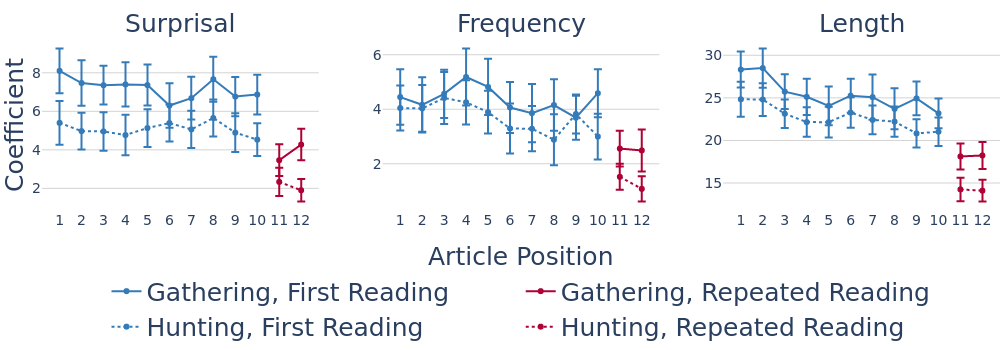

                          mean         std
has_preview reread                        
Gathering   0       196.047273  241.806356
            1       124.085413  178.581924
Hunting     0       160.412600  213.503938
            1        85.565605  154.363759


/tmp/ipykernel_1150034/1907759548.py:38: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1150034/1907759548.py:63: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



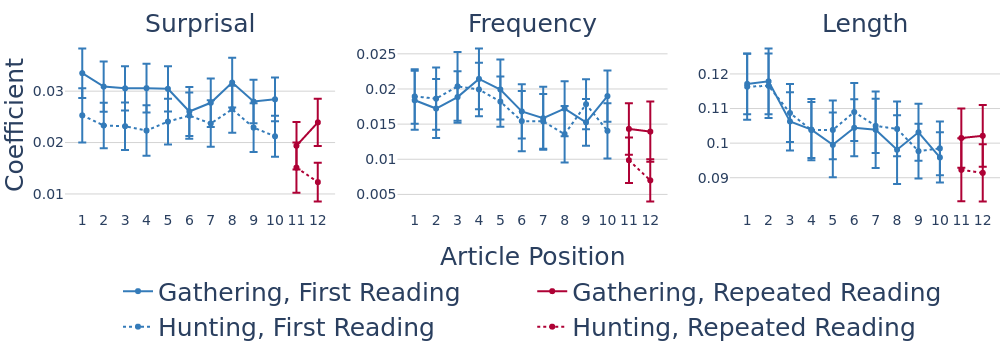

                          mean         std
has_preview reread                        
Gathering   0       124.654670  116.676064
            1        92.377776  110.186680
Hunting     0       106.027134  110.194797
            1        63.970387   96.619597


/tmp/ipykernel_1150034/1907759548.py:38: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1150034/1907759548.py:63: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



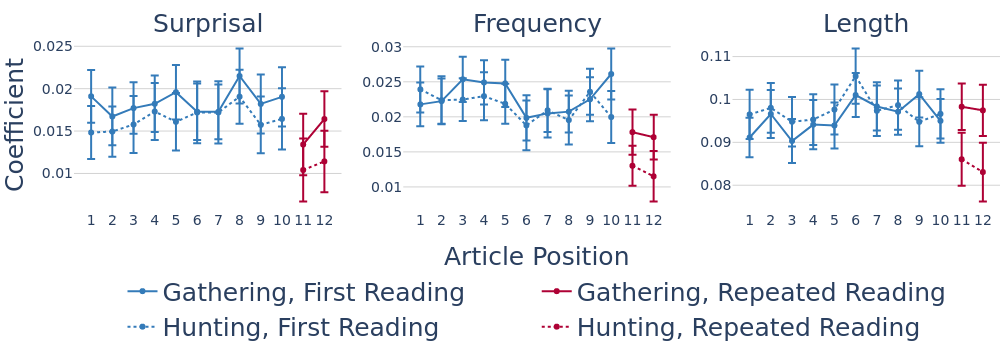

                          mean         std
has_preview reread                        
Gathering   0       135.759945  137.753829
            1        98.287916  122.999509
Hunting     0       112.966007  123.753689
            1        66.701191  103.324645


/tmp/ipykernel_1150034/1907759548.py:38: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1150034/1907759548.py:63: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



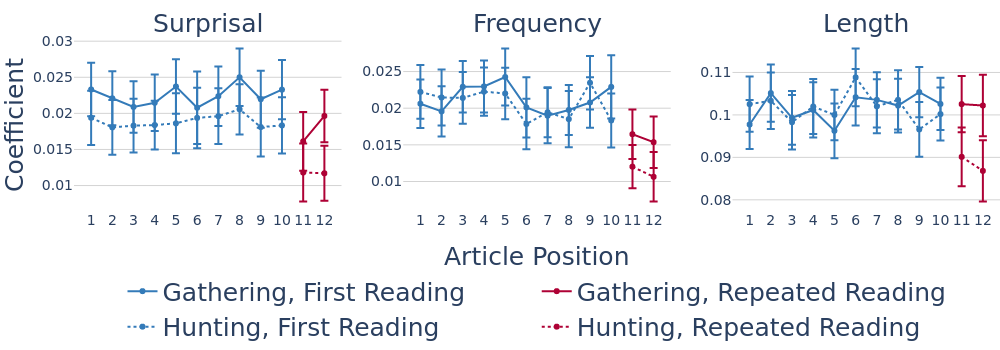

In [13]:
for i, outcome in enumerate(
    [
        "IA_DWELL_TIME",
        "IA_DWELL_TIME",
        "IA_FIRST_FIXATION_DURATION",
        "IA_FIRST_RUN_DWELL_TIME",
    ]
):
    "If i == 0 don't normalize the outcome variable. Otherwise normalized"
    df_query = f"{outcome} >= 0"
    if df_query != "":
        df = et_data_enriched.query(df_query).copy()
    else:
        df = et_data_enriched.copy()

    # normalize the outcome variable seperately for Hunting and Gathering, read and reread
    if i > 0:
        res = df.groupby(["has_preview", "reread"])[outcome].apply(
            lambda x: (x - x.mean()) / x.std()
        )
        df[outcome] = res.reset_index(level=0, drop=True).reset_index(
            level=0, drop=True
        )

    cfg = config()
    cfg.outcome_variable = outcome

    ling_featurse_formula = f"""
    {cfg.outcome_variable} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    """
    cfg.model_formula = ling_featurse_formula

    cfg.explanatory_variable = evs

    if isinstance(evs, list) and len(evs) > 1:
        cfg.explanatory_variable = "_".join(evs)
        df[cfg.explanatory_variable] = df[evs].apply(
            lambda x: "_".join([str(i) for i in x]), axis=1
        )

    res = (
        df.groupby(cfg.explanatory_variable)
        .apply(
            lambda x: run_linear_mm(
                x,
                cfg.outcome_variable,
                cfg.re_columns,
                ling_featurse_formula,
                model_res_var_name="j_model_mm",
                link_dist=Normal(),
                z_outcome=False,
                centralize_covariates=True,
                print_model_res=False,
            )[0]
        )
        .reset_index()
        .drop(columns=["level_1"])
    )

    if len(evs) > 1:
        # seperate the explanatory variable into its components in res
        res[cfg.explanatory_variable] = res[cfg.explanatory_variable].apply(
            lambda x: x.split("_")
        )
        for i in range(len(evs)):
            res[evs[i]] = res[cfg.explanatory_variable].apply(lambda x: x[i])
        res = res.drop(columns=[cfg.explanatory_variable]) # type: ignore
        # turn the numeric evs back to numeric if it's possible (is_numeric)
        for ev in evs:
            res[ev] = pd.to_numeric(res[ev], errors="ignore") # type: ignore

    # remove from res the interaction term
    res = res.query("Name != 'Wordfreq_Frequency & Length'")

    res["article_ind"] = pd.to_numeric(res["article_ind"])
    res = res.sort_values(by=["has_preview", "article_ind"])

    fig = plot_response_article_ind_hp_rr(res)

    upload(
        fig,
        "CogSci 2024 - Rereading",
        f"{'main_figures' if cfg.outcome_variable == 'IA_DWELL_TIME' else 'sm_figures'}/{cfg.outcome_variable + '_' if cfg.outcome_variable != 'IA_DWELL_TIME' else ''}response_to_ling_has_preview_article_ind{'_Z_combination' if i > 0 else ''}.pdf",
    )

In [ ]:
if "same_span_in_FR_also_gathering" in evs:  #! NOTICE
    fig = make_subplots(
        rows=3,
        cols=1,
        vertical_spacing=0.12,
        subplot_titles=["Surprisal", "Frequency", "Length"],
    )

    FR_RR_colors = colors[4:6]

    for i, ling_f in enumerate(["gpt2_Surprisal", "Wordfreq_Frequency", "Length"]):
        means_outcome = res.loc[lambda x: x["Name"] == ling_f]
        hp_colors = colors[4:6]
        # In the plot add 2 traces for read and reread with different hue
        for j, hp_val in enumerate(["Gathering", "Hunting"]):
            for k, same_span_val in enumerate([".", "True", "False"]):
                res_hp = means_outcome.loc[
                    lambda x: (x["has_preview"] == hp_val)
                    & (x["same_span_in_FR_also_gathering"] == same_span_val)
                ]

                if same_span_val == "True":
                    FR_CS_text = " - Same CS in First and Repeated Reading"
                if same_span_val == "False":
                    FR_CS_text = " - Different CS in First and Repeated Reading"
                if same_span_val == ".":
                    FR_CS_text = ""

                means_outcome_read = res_hp.loc[
                    lambda x: x["article_ind"] <= 10
                ].sort_values(by="article_ind") # type: ignore
                means_outcome_reread = res_hp.loc[
                    lambda x: x["article_ind"] > 10
                ].sort_values(by="article_ind") # type: ignore
                reread_symbol = (
                    "square"
                    if same_span_val == "True"
                    else "diamond"
                    if same_span_val == "False"
                    else "circle"
                )
                if len(means_outcome_read) > 0:
                    fig.add_trace(
                        go.Scatter(
                            x=means_outcome_read["article_ind"],
                            y=means_outcome_read["Coef."],
                            error_y=dict(
                                type="data", array=means_outcome_read["Std. Error"] * 2
                            ),
                            name=hp_val + ", " + "First Reading" + FR_CS_text,
                            marker=dict(color=colors[0], symbol="square", size=5),
                            showlegend=True if i == 0 else False,
                            line=dict(dash="solid" if j == 0 else "dot"),
                        ),
                        row=i + 1,
                        col=1,
                    )
                if len(means_outcome_reread) > 0:
                    if hp_val == "Gathering":
                        # reread_color = 'darkgreen'
                        reread_color = colors[1]

                    else:
                        reread_color = colors[1]
                    fig.add_trace(
                        go.Scatter(
                            x=means_outcome_reread["article_ind"].to_list(),
                            y=means_outcome_reread["Coef."].to_list(),
                            error_y=dict(
                                type="data",
                                array=means_outcome_reread["Std. Error"] * 2,
                            ),
                            name=hp_val + ", " + "Repeated Reading" + FR_CS_text,
                            marker=dict(
                                color=reread_color,
                                symbol=reread_symbol,
                                size=12 if reread_symbol != "circle" else 5,
                            ),
                            showlegend=True if i == 0 else False,
                            line=dict(dash="solid" if j == 0 else "dot"),
                        ),
                        row=i + 1,
                        col=1,
                    )

        fig.update_xaxes(
            title_text="Article Position" if i == 2 else "",
            # set the font size of the title to 18
            title_font=dict(size=35),
            # set the tock font to 25
            tickfont=dict(size=30),
            row=i + 1,
            col=1,
            # set the ticks to 1-12
            tickvals=np.arange(1, 13),
        )
        fig.update_yaxes(
            title_text="Coefficient",
            rangemode="tozero",
            title_font=dict(size=38),
            tickfont=dict(size=30),
            row=i + 1,
            col=1,
        )
        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

for i in [0, 1, 2]:
    # fig['layout']['xaxis' + str(i + 1)]['showgrid'] = True
    # fig['layout']['xaxis' + str(i + 1)]['gridcolor'] = 'lightgray'

    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"

fig.update_layout(
    height=1500,
    width=1600,
    # title_text="Means of Fixation Duration and Skip Rate by Article Index",
    title_x=0.5,
    font=dict(size=18),
)
# move the legend to the bottom
fig.update_layout(legend=dict(font=dict(size=32), orientation="h", y=-0.1))

# increase the font size of the subplot titles
fig.update_annotations(font_size=50)

# remove the grid background color and set the x grid to light gray


fig.show(renderer="svg")

In [10]:
if "same_span_in_FR" in evs:
    upload(
        fig,
        "CogSci 2024 - Rereading",
        f"""main_figures/{cfg.outcome_variable + '_' if cfg.outcome_variable != 'IA_DWELL_TIME' else ''}response_to_ling_has_preview_article_ind_by_diff_CS.pdf""",
    )
else:
    print(
        f"{'main_figures' if cfg.outcome_variable == 'IA_DWELL_TIME' else 'sm_figures'}/{cfg.outcome_variable + '_' if cfg.outcome_variable != 'IA_DWELL_TIME' else ''}response_to_ling_has_preview_article_ind_Z_combination.pdf",
    )
    upload(
        fig,
        "CogSci 2024 - Rereading",
        f"{'main_figures' if cfg.outcome_variable == 'IA_DWELL_TIME' else 'sm_figures'}/{cfg.outcome_variable + '_' if cfg.outcome_variable != 'IA_DWELL_TIME' else ''}response_to_ling_has_preview_article_ind_Z_combination.pdf",
    )

main_figures/response_to_ling_has_preview_article_ind_Z_combination.pdf


#### Decreasing effects in First Reading

In [22]:
for outcome in [
    "IA_DWELL_TIME",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_FIRST_FIXATION_DURATION",
]:
    print("===================================")
    print(outcome)
    print("===================================")
    ling_featurse_formula = f"""
    {outcome} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal
    + Wordfreq_Frequency & article_ind
    + Length & article_ind 
    + gpt2_Surprisal & article_ind
    + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length 
    + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) 
    + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    """
    for z_outcome in [True, False]:
        df = et_data_enriched.copy()
        if z_outcome:
            res = df.groupby(["has_preview", "reread"])[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )
            df[outcome] = res.reset_index(level=0, drop=True).reset_index(
                level=0, drop=True
            )
        print("----------------------------")
        print(z_outcome)
        print("----------------------------")
        for hp_val in ["Gathering", "Hunting"]:
            print(hp_val + " decreasing effects with artice_ind")
            sub_df = df.query(f"article_ind <= 10 and has_preview == '{hp_val}'")

            # centralize covariates
            sub_df["Wordfreq_Frequency"] = (
                sub_df["Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["gpt2_Surprisal"] = (
                sub_df["gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["Length"] = sub_df["Length"] - sub_df["Length"].mean()

            sub_df["prev_Wordfreq_Frequency"] = (
                sub_df["prev_Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["prev_gpt2_Surprisal"] = (
                sub_df["prev_gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["prev_Length"] = sub_df["prev_Length"] - sub_df["Length"].mean()

            coefs_df = run_linear_mm(
                sub_df,
                outcome,
                ["subject_id", "unique_paragraph_id"],
                ling_featurse_formula,
                model_res_var_name="j_model_mm",
                link_dist=Normal(),
                z_outcome=False,
                print_model_res=False,
            )[0]
            # print the "Name", "Coef.", "Pr(>|z|)" columns of the rows that contain the interaction term
            print(
                coefs_df.loc[lambda x: x["Name"] == "gpt2_Surprisal & article_ind"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )
            print(
                coefs_df.loc[lambda x: x["Name"] == "Wordfreq_Frequency & article_ind"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )
            print(
                coefs_df.loc[lambda x: x["Name"] == "Length & article_ind"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )

IA_DWELL_TIME
----------------------------
True
----------------------------
Gathering decreasing effects with artice_ind
                            Name     Coef.  Pr(>|z|)
10  gpt2_Surprisal & article_ind -0.000292  0.004526
                               Name     Coef.  Pr(>|z|)
8  Wordfreq_Frequency & article_ind -0.000217   0.09379
                   Name    Coef.      Pr(>|z|)
9  Length & article_ind -0.00187  1.821012e-17
Hunting decreasing effects with artice_ind
                            Name     Coef.  Pr(>|z|)
10  gpt2_Surprisal & article_ind -0.000009  0.932112
                               Name     Coef.  Pr(>|z|)
8  Wordfreq_Frequency & article_ind -0.000597  0.000008
                   Name     Coef.      Pr(>|z|)
9  Length & article_ind -0.002082  5.375304e-20
----------------------------
False
----------------------------
Gathering decreasing effects with artice_ind
                            Name    Coef.  Pr(>|z|)
10  gpt2_Surprisal & article_ind -0.07056  0.004

In [15]:
def compare_coeffs_of_2_groups(
    df_input: pd.DataFrame,
    comparison_var: str,
    comparison_var_vals: list,
    outcome_variable: str,
    mm_re_columns: list[str],
    link_dist=Normal(),
):
    assert (
        len(comparison_var_vals) == 2
    ), "comparison_var_vals must be a list of 2 values"

    df = df_input.copy()
    df["indicator"] = df[comparison_var].apply(
        lambda x: 0
        if x == comparison_var_vals[0]
        else 1
        if x == comparison_var_vals[1]
        else np.nan
    )
    # drop nans according to the indicator column
    df = df.dropna(subset=["indicator"])

    ling_featurse_formula_interactions = f"""
    {outcome_variable} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
        Wordfreq_Frequency * indicator + gpt2_Surprisal * indicator + Length * indicator +
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    """

    res = run_linear_mm(
        df.loc[lambda x: x[comparison_var] != np.nan].loc[
            lambda x: x[comparison_var] != "nan"
        ], # type: ignore
        outcome_variable,
        mm_re_columns,
        ling_featurse_formula_interactions,
        model_res_var_name="j_model_mm",
        link_dist=link_dist,
        print_model_res=False,
        centralize_covariates=[
            "Wordfreq_Frequency",
            "gpt2_Surprisal",
            "Length",
            "prev_Wordfreq_Frequency",
            "prev_gpt2_Surprisal",
            "prev_Length",
        ],
        centralize_outcome=True,
    )
    coeffs = res[0]

    coeffs = coeffs.loc[lambda x: x["Name"].str.contains("&")]
    coeffs = coeffs.loc[lambda x: x["Name"].str.contains("indicator")]
    # apply a function on Name that leaves only the first part before the &
    coeffs["Name"] = coeffs["Name"].apply(
        lambda x: x.split("&")[0][:-1] if "&" in x else x
    )

    # to coeffs add a column var_0 and var_1 for the two values of comparison_var_vals
    coeffs["var_0"] = comparison_var_vals[0]
    coeffs["var_1"] = comparison_var_vals[1]
    coeffs["var"] = comparison_var

    return coeffs


# go over all pairs of first_second_reading_types and run a linear mixed model for each pair. Use the function compare_coeffs_of_2_groups
def coeff_diff_stat_test(
    df_input: pd.DataFrame,
    comparison_var: str,
    outcome_variable: str,
    mm_re_columns: list[str],  # noqa: F811
    link_dist=Normal(),
):
    """This function runs a linear mixed model for each pair of values in comparison_var and returns a dataframe with the coefficients and p-values of the difference between the coefficients of the two groups.

    Args:
        df_input (pd.DataFrame): A dataframe with the data
        comparison_var (str): A column name in df_input
        outcome_variable (str): A column name in df_input
        re_columns (list[str]): A list of column names in df_input which are the random effects
        link_dist (_type_, optional): Defaults to Normal().

    Returns:
        coeff_diff_test_df (pd.DataFrame): A dataframe with the coefficients and p-values of the difference between the coefficients of the two groups.
        signif_coeffs (pd.DataFrame): A dataframe with the coefficients and p-values of the difference between the coefficients of the two groups where the p-value is smaller than 0.05.
    """
    reading_types = df_input[comparison_var].unique()
    pairs = list(itertools.combinations(reading_types, 2))

    df = df_input.copy()

    coeff_diff_test_df_list = []
    for pair in tqdm(pairs):
        if str(pair[0]) not in [np.nan, "nan"] and str(pair[1]) not in [np.nan, "nan"]:
            coeff_diff_test_df_list.append(
                compare_coeffs_of_2_groups(
                    df, comparison_var, pair, outcome_variable, mm_re_columns # type: ignore
                )
            )  # type: ignore
    coeff_diff_test_df = pd.concat(coeff_diff_test_df_list)
    signif_coeffs = coeff_diff_test_df.loc[lambda x: x["Pr(>|z|)"] < 0.05]
    return coeff_diff_test_df, signif_coeffs


coeff_diff_stat_test(
    df.query("has_preview == 'Gathering' and article_ind > 10"),
    "article_ind",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:11<00:00, 11.74s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.168966,0.306725,0.550871,0.581722,-0.455071,0.793004,11,12,article_ind
10,gpt2_Surprisal,0.777976,0.240144,3.239621,0.001197,0.289399,1.266553,11,12,article_ind
11,Length,-0.652193,0.518693,-1.257378,0.208617,-1.707482,0.403096,11,12,article_ind


Gathering - 11 vs. 12


In [16]:
coeff_diff_stat_test(
    df.query("has_preview == 'Gathering' and article_ind > 10"),
    "article_ind",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.168966,0.306725,0.550871,0.581722,-0.455071,0.793004,11,12,article_ind
10,gpt2_Surprisal,0.777976,0.240144,3.239621,0.001197,0.289399,1.266553,11,12,article_ind
11,Length,-0.652193,0.518693,-1.257378,0.208617,-1.707482,0.403096,11,12,article_ind


In [17]:
coeff_diff_stat_test(
    df.query("has_preview == 'Gathering' and article_ind > 10"),
    "article_ind",
    "IA_SKIP",
    cfg.re_columns,
    link_dist=Bernoulli(),
)[0]

100%|██████████| 1/1 [00:11<00:00, 11.55s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.000462,0.000838,0.551956,0.580979,-0.001242,0.002166,11,12,article_ind
10,gpt2_Surprisal,-0.000798,0.000664,-1.200345,0.230005,-0.002149,0.000554,11,12,article_ind
11,Length,0.000183,0.001427,0.128493,0.897759,-0.002721,0.003087,11,12,article_ind


Hunting 11 vs. 12


In [18]:
coeff_diff_stat_test(
    df.query("has_preview == 'Hunting' and article_ind > 10"),
    "article_ind",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

100%|██████████| 1/1 [00:15<00:00, 15.96s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,-0.239607,0.270781,-0.884872,0.376226,-0.790515,0.311302,11,12,article_ind
10,gpt2_Surprisal,-0.292133,0.217265,-1.344594,0.178757,-0.734161,0.149896,11,12,article_ind
11,Length,-0.469239,0.464418,-1.010382,0.312312,-1.414104,0.475625,11,12,article_ind


Hunting, Different CS - 11 vs. 12


In [19]:
coeff_diff_stat_test(
    df.query("has_preview == 'Gathering' and same_span_in_FR_also_gathering == False"),
    "article_ind",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.017961,0.355526,0.050521,0.959708,-0.705361,0.741284,11,12,article_ind
10,gpt2_Surprisal,0.764315,0.278015,2.749190,0.005974,0.198690,1.329940,11,12,article_ind
11,Length,-0.439105,0.601846,-0.729597,0.465637,-1.663571,0.785360,11,12,article_ind


Hunting, Same CS - 11 vs. 12


In [20]:
coeff_diff_stat_test(
    df.query("has_preview == 'Gathering' and same_span_in_FR_also_gathering == True"),
    "article_ind",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,-0.887114,0.630524,-1.406946,0.159443,-2.169926,0.395698,12,11,article_ind
10,gpt2_Surprisal,-0.585008,0.504630,-1.159283,0.246341,-1.611685,0.441668,12,11,article_ind
11,Length,0.301218,1.058175,0.284658,0.775906,-1.851654,2.454091,12,11,article_ind


Hunting, 11 - Same CS vs. Different CS


In [21]:
coeff_diff_stat_test(
    df.query("has_preview == 'Hunting' and article_ind == 11"),
    "same_span_in_FR_also_gathering",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.516646,0.477758,1.081397,0.279521,-0.455360,1.488652,True,False,same_span_in_FR_also_gathering
10,gpt2_Surprisal,-0.696159,0.404388,-1.721514,0.085158,-1.518893,0.126574,True,False,same_span_in_FR_also_gathering
11,Length,1.239150,0.849744,1.458264,0.144768,-0.489666,2.967966,True,False,same_span_in_FR_also_gathering


Hunting 12 - Same CS vs. Different CS


In [22]:
coeff_diff_stat_test(
    df.query("has_preview == 'Hunting' and article_ind == 12"),
    "same_span_in_FR_also_gathering",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,1.381333,0.457530,3.019111,0.002535,0.450482,2.312184,True,False,same_span_in_FR_also_gathering
10,gpt2_Surprisal,-0.313729,0.374731,-0.837211,0.402474,-1.076124,0.448666,True,False,same_span_in_FR_also_gathering
11,Length,0.167433,0.816171,0.205144,0.837459,-1.493079,1.827944,True,False,same_span_in_FR_also_gathering


Hunting 11 + 12 - Same CS vs. Different CS


In [23]:
coeff_diff_stat_test(
    df.query("has_preview == 'Hunting' and article_ind > 10"),
    "same_span_in_FR_also_gathering",
    cfg.outcome_variable,
    cfg.re_columns,
    link_dist=Normal(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,0.994826,0.341827,2.910320,0.003611,0.299374,1.690278,True,False,same_span_in_FR_also_gathering
10,gpt2_Surprisal,-0.429173,0.278434,-1.541378,0.123225,-0.995652,0.137306,True,False,same_span_in_FR_also_gathering
11,Length,0.549267,0.601093,0.913782,0.360832,-0.673665,1.772200,True,False,same_span_in_FR_also_gathering


In [24]:
coeff_diff_stat_test(
    df.query("has_preview == 'Hunting' and article_ind > 10"),
    "same_span_in_FR_also_gathering",
    "IA_SKIP",
    cfg.re_columns,
    link_dist=Bernoulli(),
)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:11<00:00, 11.86s/it]


,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,var_0,var_1,var
9,Wordfreq_Frequency,-0.002683,0.000915,-2.933103,0.003356,-0.004543,-0.000822,True,False,same_span_in_FR_also_gathering
10,gpt2_Surprisal,0.001186,0.000722,1.642784,0.100428,-0.000283,0.002654,True,False,same_span_in_FR_also_gathering
11,Length,-0.001676,0.001588,-1.055320,0.291279,-0.004907,0.001555,True,False,same_span_in_FR_also_gathering


#### 11 vs. 12

In [59]:
for outcome in [
    "IA_DWELL_TIME",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_FIRST_FIXATION_DURATION",
]:
    print("===================================")
    print(outcome)
    print("===================================")
    ling_featurse_formula = f"""
    {outcome} ~ 1 + is_12 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
        Wordfreq_Frequency & is_12 + gpt2_Surprisal & is_12 + Length & is_12 + 
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + is_12 | subject_id) +
        (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + is_12 | unique_paragraph_id)
    """
    for z_outcome in [True, False]:
        df = et_data_enriched.copy()
        if z_outcome:
            res = df.groupby(["has_preview", "reread"])[outcome].apply(
                lambda x: (x - x.mean()) / x.std()
            )
            df[outcome] = res.reset_index(level=0, drop=True).reset_index(
                level=0, drop=True
            )
        print("----------------------------")
        print(z_outcome)
        print("----------------------------")
        for hp_val in ["Gathering", "Hunting"]:
            print(hp_val + " effect in 11 vs. 12")
            sub_df = df.query(f"has_preview == '{hp_val}' and article_ind > 10")

            # centralize covariates
            sub_df["Wordfreq_Frequency"] = (
                sub_df["Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["gpt2_Surprisal"] = (
                sub_df["gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["Length"] = sub_df["Length"] - sub_df["Length"].mean()

            sub_df["prev_Wordfreq_Frequency"] = (
                sub_df["prev_Wordfreq_Frequency"] - sub_df["Wordfreq_Frequency"].mean()
            )
            sub_df["prev_gpt2_Surprisal"] = (
                sub_df["prev_gpt2_Surprisal"] - sub_df["gpt2_Surprisal"].mean()
            )
            sub_df["prev_Length"] = sub_df["prev_Length"] - sub_df["Length"].mean()

            # translate 12 to 1 and 11 to 0
            sub_df["is_12"] = sub_df["article_ind"].apply(lambda x: 1 if x == 12 else 0)
            coefs_df = run_linear_mm(
                sub_df,
                outcome,
                ["subject_id", "unique_paragraph_id"],
                ling_featurse_formula,
                # contrasts_dict={'article_ind': 'SDC'},
                model_res_var_name="j_model_mm",
                link_dist=Normal(),
                z_outcome=False,
                print_model_res=False,
            )[0]
            # print the "Name", "Coef.", "Pr(>|z|)" columns of the rows that contain the interaction term
            print(
                coefs_df.loc[lambda x: x["Name"] == "gpt2_Surprisal & is_12"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )
            print(
                coefs_df.loc[lambda x: x["Name"] == "Wordfreq_Frequency & is_12"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )
            print(
                coefs_df.loc[lambda x: x["Name"] == "Length & is_12"][
                    ["Name", "Coef.", "Pr(>|z|)"]
                ]
            )

IA_DWELL_TIME
----------------------------
True
----------------------------
Gathering effect in 11 vs. 12


                      Name     Coef.  Pr(>|z|)
10  gpt2_Surprisal & is_12  0.003741  0.005405
                         Name     Coef.  Pr(>|z|)
9  Wordfreq_Frequency & is_12  0.000326  0.849439
              Name     Coef.  Pr(>|z|)
11  Length & is_12 -0.001534  0.597435
Hunting effect in 11 vs. 12
                      Name     Coef.  Pr(>|z|)
10  gpt2_Surprisal & is_12 -0.001876    0.1821
                         Name     Coef.  Pr(>|z|)
9  Wordfreq_Frequency & is_12 -0.002167  0.216071
              Name     Coef.  Pr(>|z|)
11  Length & is_12 -0.002425  0.419884
----------------------------
False
----------------------------
Gathering effect in 11 vs. 12
                      Name     Coef.  Pr(>|z|)
10  gpt2_Surprisal & is_12  0.668126  0.005413
                         Name  Coef.  Pr(>|z|)
9  Wordfreq_Frequency & is_12  0.058   0.84995
              Name     Coef.  Pr(>|z|)
11  Length & is_12 -0.273548  0.598031
Hunting effect in 11 vs. 12
                      Name     Coef.  Pr

## TFD ~ relative_to_aspan & has_preview - reread == 0 

In [38]:
df_query = "reread == 0"
if df_query != "":
    df = et_data_enriched.query(df_query).copy()
else:
    df = et_data_enriched.copy()

# #!!!! CONVERT IA_DWELL_TIME TO LOG
# df['log_IA_DWELL_TIME'] = np.log(df["IA_DWELL_TIME"])


z_score_w_r_t_explanatory = True

evs = ["has_preview", "relative_to_aspan"]
# ev_list = ["article_ind_of_first_reading"]

cfg = config()
cfg.outcome_variable = "IA_DWELL_TIME"

cfg.z_score_w_r_t_explanatory = z_score_w_r_t_explanatory
z_score_text = "" if not cfg.z_score_w_r_t_explanatory else " (z-scored)"
ling_featurse_formula = f"""
{cfg.outcome_variable} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
"""
cfg.model_formula = ling_featurse_formula

cfg.explanatory_variable = evs

if isinstance(evs, list) and len(evs) > 1:
    cfg.explanatory_variable = "_".join(evs)
    df[cfg.explanatory_variable] = df[evs].apply(
        lambda x: "_".join([str(i) for i in x]), axis=1
    )

res = (
    df.groupby(cfg.explanatory_variable)
    .apply(
        lambda x: run_linear_mm(
            x,
            cfg.outcome_variable,
            cfg.re_columns,
            ling_featurse_formula,
            model_res_var_name="j_model_mm",
            link_dist=Normal(),
            z_outcome=z_score_w_r_t_explanatory,
            centralize_covariates=True,
        )[0]
    )
    .reset_index()
    .drop(columns=["level_1"])
)

if len(evs) > 1:
    # seperate the explanatory variable into its components in res
    res[cfg.explanatory_variable] = res[cfg.explanatory_variable].apply(
        lambda x: x.split("_")
    )
    for i in range(len(evs)):
        res[evs[i]] = res[cfg.explanatory_variable].apply(lambda x: x[i])
    res = res.drop(columns=[cfg.explanatory_variable]) # type: ignore
    # turn the numeric evs back to numeric if it's possible (is_numeric)
    for ev in evs:
        res[ev] = pd.to_numeric(res[ev], errors="ignore") # type: ignore

# remove from res the interaction term
res = res.query("Name != 'Wordfreq_Frequency & Length'")

Centralizing covariates:
Length                      4.371661
Wordfreq_Frequency         10.215042
prev_Length                 4.630327
gpt2_Surprisal              5.053495
prev_Wordfreq_Frequency    11.128872
prev_gpt2_Surprisal         5.731785
dtype: float64
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -307124.2448  614248.4896  614306.4896  614306.4968  614607.7414

Variance components:
                          Column        Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)         0.0119165 0.1091626
                    Wordfreq_Frequency  0.0003637 0.0190697 +0.21
                    gpt2_Surpris

/tmp/ipykernel_1625985/1450817594.py:68: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1625985/1450817594.py:92: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [54]:

fig = sp.make_subplots(
    rows=1,
    cols=3,
    subplot_titles=["Surprisal", "Frequency", "Length"],
    vertical_spacing=0.1,
    y_title="Coefficient",
)

# create a subplot for each value of ['gpt2_Surprisal', 'Wordfreq_Frequency', 'Length']
# in each subplot create a primary x axis for the has_preview and a secondary x axis for the first_second_reading types
# Use Coef. for the bar values and Std. Error for the error bars

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = ["Before Critical Span", "In Critical Span", "After Critical Span"]
fsrt_colors = colors[0:4]


for i, ling_feature in enumerate(["gpt2_Surprisal", "Wordfreq_Frequency", "Length"]):
    # add a secondary x axis for the first_second_reading_types

    for j, rr_val in enumerate(reread_vars):
        hp_res = res.loc[lambda x: x["relative_to_aspan"] == rr_val]
        fig.add_trace(
            go.Bar(
                x=hp_res.loc[lambda x: x["Name"] == ling_feature]["has_preview"],
                y=hp_res.loc[lambda x: x["Name"] == ling_feature]["Coef."],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[lambda x: x["Name"] == ling_feature]["Std. Error"]
                    * 2,
                ),
                name="Before Critical Span"
                if j == 0
                else "In Critical Span"
                if j == 1
                else "After Critical Span",
                marker=dict(color=fsrt_colors[j]),
                showlegend=True if i == 0 else False,
            ),
            row=1,
            col=i + 1,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )


fig.update_layout(
    height=375,
    width=750,
)

# # increse all font by 10
# fig.update_layout(font=dict(size=25))
# fig.update_annotations(font_size=25)

for i in range(3):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(yanchor="bottom", y=-0.42, xanchor="center", x=0.5, orientation="h")
)

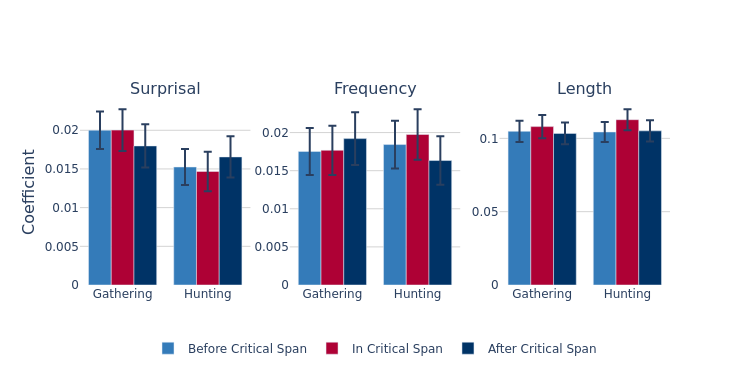

In [55]:
fig.show(renderer="png")

## Index of first reading - Hunting, Gathering

In [19]:
outcome = "IA_FIRST_RUN_DWELL_TIME"
df_query = f"{outcome} >= 0 and article_ind_of_first_reading > 0 and article_ind == 12"
if df_query != "":
    df = et_data_enriched.query(df_query).copy()
else:
    df = et_data_enriched.copy()

#! normalize IA_DWELL_TIME separately for each combination of has_preview and reread
res = df.groupby(["has_preview", "reread"])[outcome].apply(
    lambda x: (x - x.mean()) / x.std()
)
df[outcome] = res.reset_index(level=0, drop=True).reset_index(level=0, drop=True)


explanatory_var_class_names = {
    "reread": {0: "FR", 1: "RR", "0": "FR", "1": "RR"},
    "has_preview_reread": {
        "Gathering_1": "Gathering, RR",
        "Gathering_0": "Gathering, Not RR",
        "Hunting_1": "Hunting, RR",
        "Hunting_0": "Hunting, Not RR",
    },
    "has_preview": {
        "Hunting": "Hunting",
        "Gathering": "Gathering",
    },
}

explanatory_var_names = {
    "has_preview": "Condition",
    "relative_to_aspan": "Relative to Critical Span",
    "article_ind_of_first_reading": "Article Index of the First Reading",
    "first_second_reading_types": "First (<10, 10) and Second (11, 12) Readings",
    "article_ind_group_of_first_reading": "Article Index of the First Reading",
    "reread": "Reread",
    "has_preview_reread": "Condition and Reread",
}


# # init wandb
# import wandb
# wandb.login()

z_score_w_r_t_explanatory = False

evs = ["has_preview", "article_ind_of_first_reading"]

df = df.dropna(subset=evs)

cfg = config()
cfg.outcome_variable = outcome

cfg.z_score_w_r_t_explanatory = z_score_w_r_t_explanatory
z_score_text = "" if not cfg.z_score_w_r_t_explanatory else " (z-scored)"
ling_featurse_formula = f"""
{cfg.outcome_variable} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
"""
cfg.model_formula = ling_featurse_formula

cfg.explanatory_variable = evs

if isinstance(evs, list) and len(evs) > 1:
    cfg.explanatory_variable = "_".join(evs)
    df[cfg.explanatory_variable] = df[evs].apply(
        lambda x: "_".join([str(i) for i in x]), axis=1
    )

res = (
    df.groupby(cfg.explanatory_variable)
    .apply(
        lambda x: run_linear_mm(
            x,
            cfg.outcome_variable,
            cfg.re_columns,
            ling_featurse_formula,
            model_res_var_name="j_model_mm",
            link_dist=Normal(),
            z_outcome=z_score_w_r_t_explanatory,
            centralize_covariates=True,
        )[0]
    )
    .reset_index()
    .drop(columns=["level_1"])
)

if len(evs) > 1:
    # seperate the explanatory variable into its components in res
    res[cfg.explanatory_variable] = res[cfg.explanatory_variable].apply(
        lambda x: x.split("_")
    )
    for i in range(len(evs)):
        res[evs[i]] = res[cfg.explanatory_variable].apply(lambda x: x[i])
    res = res.drop(columns=[cfg.explanatory_variable]) # type: ignore
    # turn the numeric evs back to numeric if it's possible (is_numeric)
    for ev in evs:
        res[ev] = pd.to_numeric(res[ev], errors="ignore") # type: ignore

Centralizing covariates:
Length                      4.393772
gpt2_Surprisal              3.599768
prev_Length                 4.636579
prev_gpt2_Surprisal         4.116395
Wordfreq_Frequency         10.229778
prev_Wordfreq_Frequency    11.174889
dtype: float64
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_FIRST_RUN_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + Wordfreq_Frequency & Length + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
    logLik   -2 logLik      AIC         AICc        BIC     
 -20082.4106  40164.8212  40222.8212  40222.9360  40444.0427

Variance components:
                          Column        Variance   Std.Dev.    Corr.
unique_paragraph_id (Intercept)         0.01260316 0.11226380
                    Wordfreq_Frequency  0.00021829 0.01477449 -0.16
                    gpt2_S

/tmp/ipykernel_1150034/880189554.py:75: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_1150034/880189554.py:99: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [20]:
res

,Name,Coef.,Std. Error,z,Pr(>|z|),l_conf,u_conf,has_preview,article_ind_of_first_reading
0,(Intercept),-0.007923,0.051696,-0.153271,8.781846e-01,-0.113653,0.097806,Gathering,1.0
1,Wordfreq_Frequency,0.014105,0.003463,4.072907,4.642992e-05,0.007022,0.021188,Gathering,1.0
2,Length,0.099618,0.006278,15.866592,1.079460e-56,0.086777,0.112459,Gathering,1.0
3,gpt2_Surprisal,0.017625,0.003656,4.821126,1.427501e-06,0.010148,0.025102,Gathering,1.0
4,prev_Wordfreq_Frequency,-0.001568,0.001878,-0.834940,4.037515e-01,-0.005409,0.002273,Gathering,1.0
...,...,...,...,...,...,...,...,...,...
139,gpt2_Surprisal,0.015101,0.007055,2.140512,3.231344e-02,0.000672,0.029531,Hunting,9.0
140,prev_Wordfreq_Frequency,-0.003971,0.002842,-1.397562,1.622445e-01,-0.009783,0.001840,Hunting,9.0
141,prev_gpt2_Surprisal,0.012218,0.003813,3.204057,1.355058e-03,0.004419,0.020017,Hunting,9.0
142,prev_Length,-0.008389,0.005247,-1.598803,1.098645e-01,-0.019121,0.002343,Hunting,9.0


In [21]:
fig = sp.make_subplots(
    rows=3,
    cols=1,
    subplot_titles=["Surprisal", "Frequency", "Length"],
    shared_xaxes=True,
    x_title="Article Position in the First Reading",
    vertical_spacing=0.1,
)

# create a subplot for each value of ['gpt2_Surprisal', 'Wordfreq_Frequency', 'Length']
# in each subplot create a primary x axis for the has_preview and a secondary x axis for the first_second_reading types
# Use Coef. for the bar values and Std. Error for the error bars

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
article_ind_of_first_vars = [i for i in range(1, 11)]


for i, ling_feature in enumerate(["gpt2_Surprisal", "Wordfreq_Frequency", "Length"]):
    # add a secondary x axis for the first_second_reading_types

    for j, hp_val in enumerate(has_preview_vars):
        hp_res = res.loc[lambda x: x["has_preview"] == hp_val].sort_values(
            by=["article_ind_of_first_reading"]
        ) # type: ignore
        fig.add_trace(
            go.Scatter(
                x=hp_res.loc[lambda x: x["Name"] == ling_feature][
                    "article_ind_of_first_reading"
                ],
                y=hp_res.loc[lambda x: x["Name"] == ling_feature]["Coef."],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[lambda x: x["Name"] == ling_feature]["Std. Error"]
                    * 2,
                ),
                name="Hunting" if j == 0 else "Gathering",
                marker=dict(color=colors[1]),
                showlegend=True if i == 0 else False,
                # set the line color, make it dashed if hp_val is Hunting
                line=dict(color=colors[1], dash="dot")
                if hp_val == "Hunting"
                else dict(color=colors[1]),
            ),
            row=i + 1,
            col=1,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    # set the x axis title to ling_feature
    fig.update_xaxes(
        # title_text="Article index of the first reading",
        # set the font size of the title to 18
        # title_font=dict(size=20),
        # set the tock font to 25
        tickfont=dict(size=14),
        row=i + 1,
        col=1,
    )
    fig.update_yaxes(
        title_text="Coefficient" if outcome == "IA_DWELL_TIME" else "",
        # title_font=dict(size=25),
        tickfont=dict(size=14),
        row=i + 1,
        col=1,
    )

fig.update_layout(
    height=1000,
    width=550,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)


for i in range(3):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"

# remove the margins
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
    )
)

# add an annotation at the top with the outcome variable name
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.1,
    text=outcome_name_mapping[outcome],
    font=dict(size=28),
    showarrow=False,
)

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.13,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)

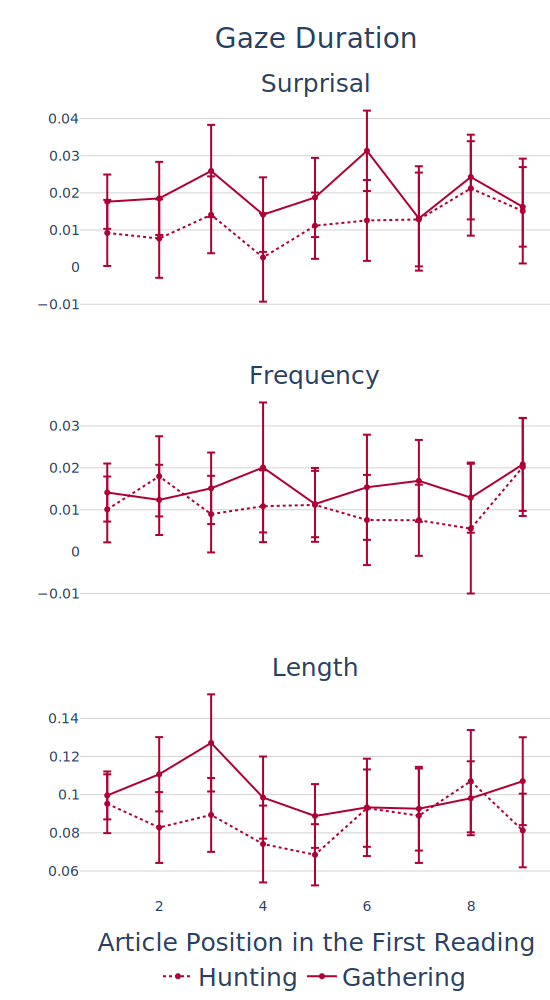

In [22]:
fig.show(renderer="svg")

In [23]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    f"sm_figures/response_to_ling_article_ind_of_first_reading_z_{outcome}.pdf",
)